「文字単位RNNによる名前（苗字）の生成」
======================================
【原題】NLP From Scratch: Generating Names with a Character-Level RNN

【原著】[Sean Robertson](https://github.com/spro/practical-pytorch)

【元URL】https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年10月25日

【チュトーリアル概要】

言語の種類を指定し、名前（苗字）を生成するモデルを、文字レベルのRNNモデルで構築します。

---

本チュートリアルは、"ゼロから作るNLP "をテーマとした3つのチュートリアルの2つ目です。

最初のチュートリアルでは、(日本語版「3_2_文字単位RNNによる名前（苗字）の分類」）

RNNを使って、苗字を入力した際に、その苗字が属する言語を分類、推論しました。



今回は、その逆で、言語から苗字を生成してみましょう。

    $ python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    $ python sample.py German GER
    Gerren
    Ereng
    Rosher

    $ python sample.py Spanish SPA
    Salla
    Parer
    Allan

    $ python  sample.py Chinese CHI
    Chan
    Hang
    Iun


本チュートリアルでも、線形層を伴う小さなRNNモデルを手作りします。

前回との大きな違いは、苗字の文字を読み込んでカテゴリ（=言語）を予測するのではなく、カテゴリ（=言語）を入力して、苗字（名前）を1文字ずつ出力することです。

再帰的に文字を予測することで、文などの言語を生成するモデルは、しばしば「言語モデル」と呼ばれます。

今回はカテゴリから名前を生成していますが、例えば単語やもっと高次元な構造（画像）などを入力して、文などの言語を生成することも可能です。







**本チュートリアルを読むにあたっての推奨記事:**

本チュートリアルでは、PyTorchとPythonがインストール済みであり、また読者がテンソルについて理解していることを前提としています。


-  https://pytorch.org/ PyTorchのインストールガイドです
-  [DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) は、PyTorchを始める方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [LEARNING PYTORCH WITH EXAMPLES](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) は、PyTorchをより広く・深く理解する方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [PyTorch for Former Torch Users](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) は、PyTorchの前身であるLua Torchユーザー向けの記事です




以下の記事は、RNNの概要と仕組みを理解するにあたっては、以下の記事がおすすめです。

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
   には実例が豊富です。
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   はLSTMに関する記事ですが、RNNの一般的な理解にとっても有益です。

<br>

（日本語訳注：RNNを理解するにあたって、個人的に役立った日本語の記事を以下に記載します

- [再帰型ニューラルネットワークの「基礎の基礎」を理解する](https://www.imagazine.co.jp/%E5%86%8D%E5%B8%B0%E5%9E%8B%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D/)
- [リカレントニューラルネットワーク（RNN）の基礎](https://qiita.com/_oshiritantei/items/3494590a92c609cf0e50)

<br>

また、前回のチュートリアル記事 「3_2_文字単位RNNによる名前（苗字）の分類」を一読することもおすすめです。


データの準備
=====

---

【注釈】

データを[ここ](https://download.pytorch.org/tutorial/data.zip)からダウンロードし、カレント・ディレクトリに展開してください


（日本語訳注：日本語版の本チュートリアルでは自動的にファイルをダウンロードして使用可能にするセルを冒頭に追加しています）

---




データ準備処理の詳細は、前回のチュートリアルを参照してください。

ここでは簡単に説明します。

まず、各行が苗字となっているプレーンテキストファイル `data/names/[言語名].txt` が複数あります。

このファイルの各行をリストに分割し、UnicodeをASCIIに変換し、最終的に`{language} [names ....]}`という形式の辞書を作成します。

In [1]:
%matplotlib inline

In [2]:
# 日本語訳注：サンプルデータをダウンロードし、zipファイルを解凍するセルを追加
import os
import subprocess
import zipfile
if os.path.exists('./data'):
  print("./dat/ already exists")
else:
  subprocess.run("wget https://download.pytorch.org/tutorial/data.zip",shell=True, check=True)
  with zipfile.ZipFile("./data.zip") as zipfile:
    zipfile.extractall(".")

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Greek', 'French', 'Chinese', 'Vietnamese', 'Irish', 'Portuguese', 'English', 'Czech', 'Dutch', 'Spanish', 'Japanese', 'Italian', 'Russian', 'Arabic', 'Korean', 'German', 'Polish', 'Scottish']
O'Neal


ネットワークの作成
=====

これから作成するネットワークは、前回のチュートリアルのRNNに、カテゴリテンソルの引数を追加するよう、拡張したものです。

カテゴリテンソルは、他のテンソルと同様にネットワークに入力されます。入力文字と同様にワンホットベクトルで表現されています。




次に、出力結果を解説します。

出力結果は、次に来る文字の確率として解釈できます。

そこで、ネットワークは順次、次の文字を選ぶ際に、出力される可能性が最も高い文字を次の入力文字として採用します。



今回は、（隠れ状態と出力を組み合わせた後に）2つ目の線形レイヤー`o2o`を追加して、ネットワークの表現力を向上させます。

また、指定した確率で[入力の一部をランダムにゼロにするドロップアウト層](https://arxiv.org/abs/1207.0580)も追加しました（今回は確率は0.1を使用）。

ドロップアウト層は通常、入力を曖昧にすることで、過学習を抑制するために導入されます。

今回はネットワークの最後にドロップアウト層を使用しています。

これは出力データにノイズを加え、ネットワークによって選択される文字のパターンを増やすことにつながります。

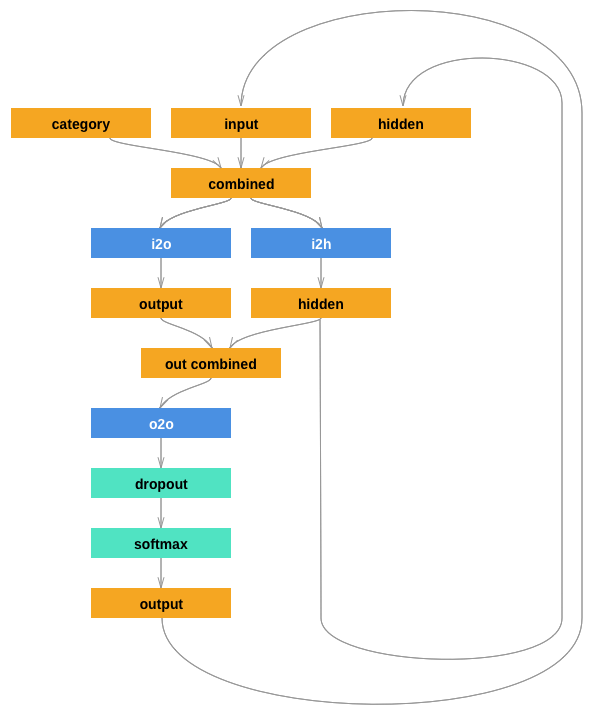

In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

訓練
=====
訓練の用意
-----
最初に、`(category, line)`という形式のペアをランダムに取得する、補助関数を作成します。


In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

各学習ステップのネットワークへの入力は

 `(category, current letter, hidden state)`という形式になり、

 出力は`(next letter, next hidden state)`という形式になります。

したがって、各学習セットごとに、カテゴリ、入力文字セット、出力/正解文字セットが必要となります。



各学習ステップでは現在の文字から次の文字を予測しています。

そのため、文字のペアはその行における連続している二文字をグループ化したものです。

例えば、`"ABCD<EOS>"`という行の場合、("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS")を作成します。

（日本語訳注：EOSは文の終わりを意味しており、End Of Sequenceの略称です。）

<br>

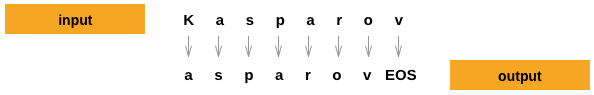

カテゴリのテンソルは、サイズ`<1 x n_categories>`の[ワンホットテンソル](https://en.wikipedia.org/wiki/One-hot)です。

ネットワークを学習させる際には、学習ステップごとに、このようなテンソルをネットワークに投入することになります。




カテゴリのテンソルをワンホットテンソルに変換してネットワークに毎ステップ投入する手法は、ネットワーク設計の選択肢の一つです。

したがって、例えば初期の隠れた状態やネットワーク上の他のパートに、初めからカテゴリの情報を含めておくこともできます。

<br>

（日本語訳注：こうすれば、毎ステップ同じものを入力するというムダを省く作戦をとることができます。ですが本チュートリアルは分かりやすさを重視して、毎ステップ、同じカテゴリテンソルを入力する作戦を使用しています）。




In [6]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

ここで、訓練中に使える便利な補助関数として、`randomTrainingExample`を作成します。

これは、`(category、line)`という形式のランダムなペアを取得し、それを`(category、input、target)`という形式のテンソルに変換する関数です。

In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

ネットワークの訓練
-----
ネットワークの最後の出力だけを使う分類タスクとは異なり、各文字を入力するステップごとに予測を実施しているので、ステップごとに損失を計算します。

autogradの機能を使えば、これらのステップごとの損失を単純に合計し、最後にまとめて誤差逆伝播（バックプロパゲーション）を実行することができます。

In [8]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

訓練にかかる時間を追跡するために、`timeSince(timestamp)`関数を追加し、大まかな訓練時間を出力します。

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

訓練はこれまでと同じ流れです。

関数`train`を何度も呼び出して数分待ち、現在の訓練時間と損失を`print_every`のタイミングごとにprint文で出力します。

また、後で結果をプロットするために、`plot_every`ごとの平均損失を`all_losses`変数に保存します。

In [10]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 26s (5000 5%) 2.6488
0m 47s (10000 10%) 2.9611
1m 7s (15000 15%) 2.3701
1m 29s (20000 20%) 2.6065
1m 50s (25000 25%) 3.2050
2m 11s (30000 30%) 2.5698
2m 32s (35000 35%) 2.2254
2m 53s (40000 40%) 3.1526
3m 14s (45000 45%) 2.8127
3m 33s (50000 50%) 3.0241
3m 54s (55000 55%) 2.6416
4m 14s (60000 60%) 1.9069
4m 34s (65000 65%) 1.9767
4m 54s (70000 70%) 2.7185
5m 14s (75000 75%) 2.8503
5m 36s (80000 80%) 2.6110
5m 57s (85000 85%) 2.4133
6m 17s (90000 90%) 2.4131
6m 38s (95000 95%) 2.7829
6m 59s (100000 100%) 2.6374


損失のプロット
-----
`all_losses`変数にある、損失の履歴をプロットすると、ネットワークが学習していく様子が分かります。

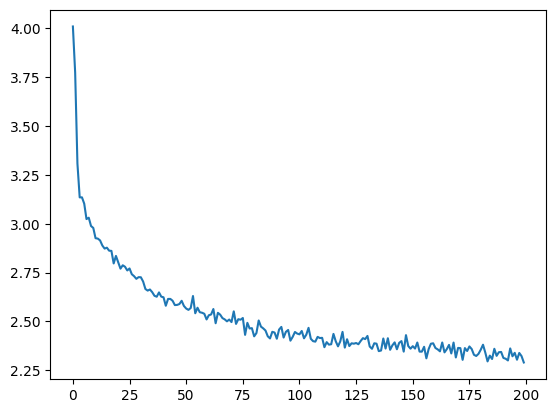

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

（日本語訳追記）

[1] 上記の結果は実行の度に変わります。

[2] 今回は検証のデータセットを用意していないので、過学習する恐れがあります。


ネットワークから苗字をサンプリング
=====
（日本語訳注：ここでいう「サンプリング」とは、ネットワークに苗字を生成させることを指しています。）



苗字をサンプリング（収集、生成）するために、ネットワークに文字を入力し、次の文字が何かを推論させ、それを次の文字として入力し、EOSトークンが出現するまで繰り返します。

- 入力カテゴリ、一番目の文字、空の隠れ状態を格納するためのテンソルを作成する
- 一番目の文字を使って、文字列`output_name`を作成する
- 出力される文字列の長さが最大値になるまで、以下を行う
	- 現在の文字をネットワークに投入する
	- 最も確率が高い文字を予測結果をもとに、次の文字と、次の隠れ状態を取得する
	- 文字がEOSの場合はここでストップする
	- EOS以外の文字の場合は、文字を`output_name`に追加して処理を継続する
- 最終的な出力結果として、苗字を返す

---
【注釈】

苗字の一文字目を明示的に与えるという方法以外に、「文頭」を意味する特殊なトークンを入力し、ネットワークに一文字目から推論させる方法も考えられます。

---

In [12]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovellov
Uantovev
Sharikov
Gerter
Ereren
Rour
Sarer
Parer
Alane
Chan
Hai
Iun


In [13]:
# （日本語訳注：） せっかくなので、日本語の場合もやってみましょう
samples('Japanese', 'YTSOMTS')

# 日本語の結果は微妙ですね・・・（他の英語系言語と同じネットワークなので、完璧な生成は無理があると思います・・・）


Yanaka
Taka
Sanaki
Oaka
Maraki
Taka
Sakiar


演習
=====
- 本チュートリアルとは異なる、カテゴリ -> 行 を予測するデータセットで試してみてください。例えば以下のようなものが考えられます。
	- フィクションの物語 -> キャラクター名
	- スピーチの一部 -> 単語
	- 国 → 都市
- 一番目の文字を明示的に与えなくてもサンプリングができるように、「文頭」トークンを使用するパターンを実装してみてください。
- ネットワークのサイズをさらに大きくするか、ネットワークの構造を改善することで、より良い結果を得られるよう工夫してみてください。例えば以下のような方法が考えられます。
	- `nn.LSTM` と `nn.GRU` レイヤーを試す
	- これらのRNNを組み合わせ、さらに高次元なネットワークを構築する


